### 新闻主题分类

此部分使用多项式朴素贝叶斯模型，进行新闻主题分类，主要设计：分词、文本处理（词频、去重、停用词）、特征提取、模型构建训练、模型评估

数据说明：

- "./Database/SogouC/Sample"下9个文件夹表示9个类别
- 文件夹对应标签在"./Database/SogouC/ClassList.txt"文件中，如下：

		C000008	财经
		C000010	IT
		C000013	健康
		C000014	体育
		C000016	旅游
		C000020	教育
		C000022	招聘
		C000023	文化
		C000024	军事

In [1]:
import os
import time
import random
import jieba  #处理中文
import nltk  #处理英文
import sklearn
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

### 一、词去重

In [9]:
# 词去重（主要是将停用词文件中的词去重）
def make_word_set(words_file):
    words_set = set()
    with open(words_file, 'r',encoding="utf-8") as fp:
        for line in fp.readlines():
            word = line.strip()
            if len(word)>0 and word not in words_set: # 去重
                words_set.add(word)
    return words_set

### 二、文本处理

In [12]:
# 文本处理，也就是样本生成过程
def text_processing(folder_path, test_size=0.2):
    folder_list = os.listdir(folder_path)  # 返回目录下的文件和文件夹名列表
    data_list = []
    class_list = []

    # 遍历文件夹
    for folder in folder_list:
        new_folder_path = os.path.join(folder_path, folder)  # 路径拼凑
        files = os.listdir(new_folder_path)
        # 读取文件
        j = 1
        for file in files:
            if j > 100: # 怕内存爆掉，只取100个样本文件，你可以注释掉取完
                break
            with open(os.path.join(new_folder_path, file), 'r', encoding="utf-8") as fp:
                raw = fp.read()
            # jieba中文分词
            # jieba.enable_parallel(4) # 开启并行分词模式，参数为并行进程数，不支持windows
            word_cut = jieba.cut(raw, cut_all=False) # 精确模式，返回的结构是一个可迭代的genertor
            word_list = list(word_cut) # genertor转化为list，每个词unicode格式
            # jieba.disable_parallel() # 关闭并行分词模式
            
            data_list.append(word_list) # 训练集list
            class_list.append(folder) #类别
            j += 1
    
    # 手动划分训练集和测试集
    data_class_list = list(zip(data_list, class_list))  # 打包为list，成为[(样本1特征,样本1类别),(样本2特征,样本2类别),...(样本3特征,样本3类别)]
    random.shuffle(data_class_list)
    index = int(len(data_class_list)*test_size)+1
    train_list = data_class_list[index:]
    test_list = data_class_list[:index]
    train_data_list, train_class_list = list(zip(*train_list))  # 解包
    test_data_list, test_class_list = list(zip(*test_list))
    
    # 其实可以用sklearn自带的部分做
    # rain_data_list, test_data_list, train_class_list, test_class_list = sklearn.cross_validation.train_test_split(data_list, class_list, test_size=test_size)
    

    # 统计词频放入all_words_dict
    all_words_dict = {}
    for word_list in train_data_list:
        for word in word_list:
            if word in all_words_dict:
                all_words_dict[word] += 1
            else:
                all_words_dict[word] = 1

    # key函数利用词频进行降序排序（字典排序，可以上网找）
    all_words_tuple_list = sorted(all_words_dict.items(), key=lambda f:f[1], reverse=True) # 内建函数sorted参数需为list
    all_words_list = list(zip(*all_words_tuple_list))[0]
    
    return all_words_list, train_data_list, test_data_list, train_class_list, test_class_list

### 三、特征词选取

In [4]:
def words_dict(all_words_list, deleteN, stopwords_set=set()):
    # 选取特征词
    feature_words = []
    n = 1
    for t in range(deleteN, len(all_words_list), 1):  # 选取特征词中[(deleteN, len(all_words_list)]
        if n > 1000: # feature_words的维度1000
            break
        # 如果不是数字、不是停用词、长度大于1小于5   
        if not all_words_list[t].isdigit() and all_words_list[t] not in stopwords_set and 1<len(all_words_list[t])<5:
            feature_words.append(all_words_list[t])  # 记为特征词
            n += 1
    return feature_words

### 四、文本特征

In [6]:
# 文本特征
def text_features(train_data_list, test_data_list, feature_words, flag='nltk'):
    def text_features(text, feature_words):
        text_words = set(text)
        
        if flag == 'nltk':
            #  nltk特征 dict
            # 遍历特征词，如果该词在text_words中，返回word:1，否则返回word:0
            features = {word:1 if word in text_words else 0 for word in feature_words}
        elif flag == 'sklearn':
            #  sklearn特征 list
            # 遍历特征词，如果该词在text_words中，返回1，否则返回0
            features = [1 if word in text_words else 0 for word in feature_words]
        else:
            features = []

        return features
    train_feature_list = [text_features(text, feature_words) for text in train_data_list]
    test_feature_list = [text_features(text, feature_words) for text in test_data_list]
    return train_feature_list, test_feature_list

### 五、分类

In [7]:
# 分类，同时输出准确率等
def text_classifier(train_feature_list, test_feature_list, train_class_list, test_class_list, flag='nltk'):

    if flag == 'nltk':
        # 使用nltk分类器
        train_flist = list(zip(train_feature_list, train_class_list))
        test_flist = list(zip(test_feature_list, test_class_list))
        classifier = nltk.classify.NaiveBayesClassifier.train(train_flist)
        test_accuracy = nltk.classify.accuracy(classifier, test_flist)
    elif flag == 'sklearn':
        # sklearn分类器
        classifier = MultinomialNB().fit(train_feature_list, train_class_list)
        test_accuracy = classifier.score(test_feature_list, test_class_list)
    else:
        test_accuracy = []
    return test_accuracy

### 六、测试

start
[0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5263157894736842, 0.5263157894736842, 0.5789473684210527, 0.5263157894736842, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5263157894736842, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5263157894736842, 0.5263157894736842, 0.47368421052631576, 0.47368421052631576, 0.47368421052631576, 0.47368421052631576, 0.47368421052631576, 0.47368421052631576, 0.47368421052631576, 0.47368421052631576, 0.47368421052631576]

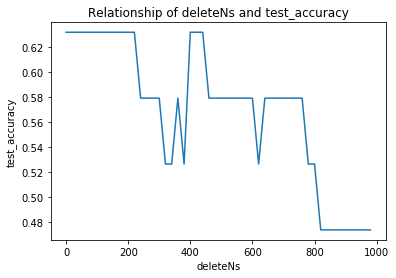

finished


In [17]:
print("start")

# 文本预处理
folder_path = './Database/SogouC/Sample'
all_words_list, train_data_list, test_data_list, train_class_list, test_class_list = text_processing(folder_path, test_size=0.2)

# 生成stopwords_set
stopwords_file = './stopwords_cn.txt'
stopwords_set = make_word_set(stopwords_file)

# 文本特征提取和分类
#flag = 'nltk'
flag = 'sklearn'
deleteNs = range(0, 1000, 20)  # 0 20 40 ...
test_accuracy_list = []
for deleteN in deleteNs:  # 遍历删除前deleteN特征词的数目，这里删除前面的，主要是降序排序后，前面的词出现次数比较多，可能是比较普遍的词
    # 不能给模型带来好的效果，我们可以做适当的删除
    feature_words = words_dict(all_words_list, deleteN, stopwords_set)
    train_feature_list, test_feature_list = text_features(train_data_list, test_data_list, feature_words, flag)
    test_accuracy = text_classifier(train_feature_list, test_feature_list, train_class_list, test_class_list, flag)
    test_accuracy_list.append(test_accuracy)
print(test_accuracy_list)

# 结果评价
#plt.figure()
plt.plot(deleteNs, test_accuracy_list)
plt.title('Relationship of deleteNs and test_accuracy')
plt.xlabel('deleteNs')
plt.ylabel('test_accuracy')
plt.show()
#plt.savefig('result.png')

print("finished")